# Tutorial 7

## Classical Application

In [2]:
import numpy as np
from numba import jit
from numpy.random import randint, rand

import matplotlib.pyplot as plt
"""
  Simple MC for Ising model
  * rewritten for readibility, simplified
  * with added numba speed-up (order of magnitude)
  * code for heat-bath algorithm
  * magnetization, susceptibility, plots

  @JakubTwo2021
"""

'\n\n  Simple MC for Ising model\n  * rewritten for readibility, simplified\n  * with added numba speed-up (order of magnitude)\n  * code for heat-bath algorithm\n  * magnetization, susceptibility, plots\n\n  @JakubTwo2021\n\n'

In [3]:
## here @jit means no-python just in time (compilation)
## ... comment out to see how much it speeds up ...
@jit(nopython=True)
def sweepHB(s,beta,L):
    # all variables we wish to change in the code should be listed
    # no need to return s -- it is just overwritten!

    for k in range(L*L):

        # pick a random site
        ix, iy = randint(L), randint(L)

        # calculate the sum over neighbouring spins
        sum_loc = ( s[(ix+1)%L,iy] + s[(ix-1)%L,iy]
                    + s[ix,(iy+1)%L] + s[ix,(iy-1)%L] )

        ## heat-bath
        prob_pls = 1./( 1. + np.exp(-2*beta*sum_loc) )
        if ( rand() < prob_pls ):
            s[ix,iy] =  1
        else:
            s[ix,iy] = -1

size temp  magnetization susceptibility
  10 5.000   0.1336640    0.5617097
  10 4.800   0.1366040    0.6067906
  10 4.600   0.1433720    0.6991432
  10 4.400   0.1510040    0.8054964
  10 4.200   0.1560240    0.9011298
  10 4.000   0.1689280    1.0866452
  10 3.800   0.1792200    1.2943105
  10 3.600   0.1944680    1.6205421
  10 3.400   0.2136280    2.0540115
  10 3.200   0.2316520    2.5254316
  10 3.000   0.2790920    3.7365831
  10 2.800   0.3379840    5.8102134
  10 2.600   0.4476040    10.2344367
  10 2.400   0.6156920    16.6445853
  10 2.200   0.8264640    20.7188971
  10 2.000   0.9034240    4.1464221
  10 1.800   0.9569280    0.1226313
  10 1.600   0.9786000    0.0445675
  10 1.400   0.9910280    0.0189302
  10 1.200   0.9969680    0.0060339


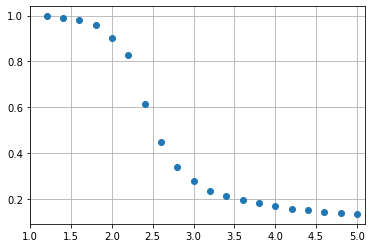

In [4]:
mcs_max = 5000
mcs_eq  = 5000
magnet = np.zeros((mcs_max))

print( "size temp  magnetization susceptibility" )

measure = []
tmax,tmin,tst = 5,1,-0.2
temp_tab = np.arange(tmax,tmin,tst)
Lbig = 10

# lattice of ordered spins: Numpy array
spins = np.ones( (Lbig,Lbig) )
Nbig = Lbig*Lbig

for temp in temp_tab:
    beta = 1./temp

    # equilibration
    for mcs in range(mcs_eq):
        sweepHB(spins,beta,Lbig)

    # accumulate measurements
    for mcs in range(mcs_max):
        sweepHB(spins,beta,Lbig)
        magnet[mcs]= np.sum(spins*1.0/Nbig)

    mag = np.mean(np.abs(magnet))
    chi = np.var(magnet)*beta*Nbig
    measure.append((Lbig,1./beta, mag, chi))
    print("{0:4d} {1:.3f}   {2:.7f}    {3:.7f}".
          format(Lbig, 1./beta, mag, chi) )


# simple plot of the results
mtab = np.array(measure)
plt.grid()
plt.xlim(1,5.1)
plt.plot(mtab[:,1], mtab[:,2],'o')

plt.savefig('magnet.png')

## Quantum application

In [25]:
## here @jit means no-python just in time (compilation)
## ... comment out to see how much it speeds up ...
@jit(nopython=True)
def sweepHB_Q(s, beta, L, dtau, h, J, M):
    # all variables we wish to change in the code should be listed
    # no need to return s -- it is just overwritten!
    gamma = -0.5*np.log(np.tanh(dtau*h))
    for k in range(L*L):

        # pick a random site
        ix, iy = randint(L), randint(M)

        # calculate the sum over neighbouring spins
        ham = ( -J*dtau*(s[(ix+1)%L,iy] + s[(ix-1)%L,iy])
                    - gamma*(s[ix,(iy+1)%M] + s[ix,(iy-1)%M]) )

        ## heat-bath
        prob_pls = 1./( 1. + np.exp(2*ham) )
        if ( rand() < prob_pls ):
            s[ix,iy] =  1
        else:
            s[ix,iy] = -1

In [31]:
def onsager(h, beta, M, J):
    return np.power((1 - np.power((np.sinh(beta*h/M))/(np.sinh(beta*J/M)), 2)), 1/8)

In [39]:
mcs_max = 5000
mcs_eq  = 5000
magnet = np.zeros((mcs_max))
beta = 5
J = 1
M = 30
dtau = beta/M

print( "size h  magnetization susceptibility  theory" )

measure = []
hmin,hmax,hst = 0.1,3,0.05
h_tab_theory = np.arange(hmin,1,hst)
h_tab = np.concatenate((h_tab_theory, np.arange(1+hst,hmax,hst)))
Lbig = 20

# lattice of ordered spins: Numpy array
spins = np.ones( (Lbig,Lbig) )
Nbig = Lbig*Lbig

for h in h_tab:

    # equilibration
    for mcs in range(mcs_eq):
        sweepHB_Q(spins,beta,Lbig, dtau, h, J, M)

    # accumulate measurements
    for mcs in range(mcs_max):
        sweepHB_Q(spins,beta,Lbig, dtau, h, J, M)
        magnet[mcs]= np.sum(spins*1.0/Nbig)

    mag = np.mean(np.abs(magnet))
    chi = np.var(magnet)*beta*Nbig
    if h < J:
        theory = onsager(h, beta, M, J)
    else:
        theory = -1.0
    measure.append((Lbig, h, mag, chi, theory))
    print("{0:4d} {1:.3f}   {2:.7f}    {3:.7f}  {4:.7f} ".
          format(Lbig, h, mag, chi, theory) )

size h  magnetization susceptibility  theory
  20 0.100   0.9988000    0.0434000  0.9987560 
  20 0.150   0.9975700    0.0804902  0.9971852 
  20 0.200   0.9951700    0.1382622  0.9949561 
  20 0.250   0.9935800    0.1641272  0.9920365 
  20 0.300   0.9907010    0.2655272  0.9883828 
  20 0.350   0.9850580    0.4801133  0.9839366 
  20 0.400   0.9791560    0.9378953  0.9786218 
  20 0.450   0.9755380    0.9027611  0.9723386 
  20 0.500   0.9652950    1.6598759  0.9649562 
  20 0.550   0.9581590    2.1265514  0.9563001 
  20 0.600   0.9478030    2.6520564  0.9461334 
  20 0.650   0.9444660    2.2822297  0.9341253 
  20 0.700   0.7845030    1248.7419587  0.9197951 
  20 0.750   0.9088010    8.0538548  0.9024087 
  20 0.800   0.8952840    7.8449187  0.8807599 
  20 0.850   0.8839990    7.4821460  0.8526461 
  20 0.900   0.8622820    15.9338050  0.8132963 
  20 0.950   0.6039890    680.9738722  0.7483010 
  20 1.050   0.6530150    131.3900919  -1.0000000 
  20 1.100   0.7311040    40.77488

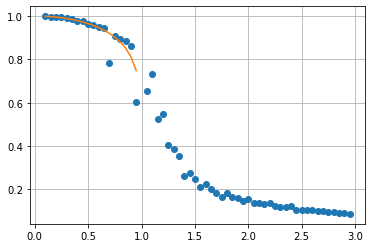

In [40]:
# simple plot of the results
mtab = np.array(measure)
plt.grid()
# plt.xlim(1,5.1)
plt.plot(mtab[:,1], mtab[:,2],'o')
plt.plot(h_tab_theory, onsager(h_tab_theory, beta, M, J))

plt.savefig('magnet_Q.png')